In [1]:
from hcipy import *
from hcipy import atmosphere
from hcipy import fourier
import numpy as np
from matplotlib import pyplot as plt
import turb_sims as ts
from functools import partial
from importlib import reload

In [2]:
# lmao
import warnings
warnings.filterwarnings("ignore")

# OG paper: Simulations

In this code we use the modulated PyWFS to simulate OG's behavior across modes and with respect to seeing.

## Setup

In [3]:
wavelength = 800.0e-9
Dtel = 6.5
pad = 2
Dgrid = 60/56 * Dtel
n_bin = 2 #this allows us to oversample our pupil
grid = make_pupil_grid(60*n_bin, Dgrid) # could suepersample this to stop aliasing errors
grid_pad = make_pupil_grid(60*n_bin*pad, Dgrid*pad)
wfs_grid = make_pupil_grid(120*n_bin, 2 * Dgrid)

In [4]:
# Padding math
h_pad = 60*n_bin*pad
h_reg = 60*n_bin

def window_field(field, new_grid, h, x0=0, y0=0):
    cropped_field = field.shaped[(y0-h//2):(y0+h//2), (x0 - h//2):(x0+h//2)]
    return Field(cropped_field.ravel(), new_grid)

crop_pad = partial(window_field, new_grid=grid, h=h_reg, x0=h_pad//2, y0=h_pad//2)

In [5]:
# setting up the pyramid pwfs
pwfs = PyramidWavefrontSensorOptics(grid, wfs_grid, separation=Dgrid, pupil_diameter=Dtel, wavelength_0=wavelength, q=4) # q gives pixels per lambda over D
mpwfs = ModulatedPyramidWavefrontSensorOptics(pwfs, 3 * wavelength/Dtel, num_steps=20) #, fast_modulation_method=True) # had to exlude bc not on sebastiaans version

In [6]:
aperture = evaluate_supersampled(make_magellan_aperture(), grid, 8) # anti aliasing filter => softens filter
wf = Wavefront(aperture, wavelength)
wf.total_power = 1.0

In [7]:
# shoing we can window down from 
aperture_pad = evaluate_supersampled(make_magellan_aperture(), grid_pad, 8) 
h_pad = 60*n_bin*pad
h_reg = 60*n_bin
crop_aperture = crop_pad(aperture_pad)

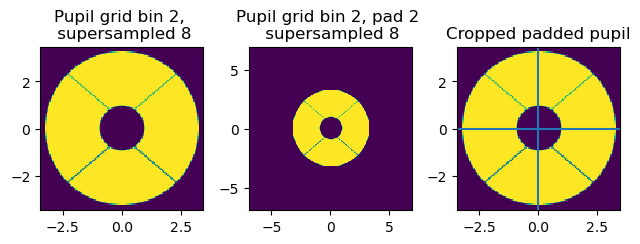

In [8]:
plt.subplot(1,3,1)
plt.title(f"Pupil grid bin {n_bin}, \n supersampled 8")
imshow_field(aperture)

plt.subplot(1,3,2)
plt.title(f"Pupil grid bin {n_bin}, pad {pad} \n supersampled 8")
imshow_field(aperture_pad)

plt.subplot(1,3,3)
plt.title(f"Cropped padded pupil")
imshow_field(crop_aperture)
plt.axhline(0)
plt.axvline(0)

plt.tight_layout()
plt.show()

In [9]:
def pywfs_int(wf_list, bin, count=20):
    im = 0
    for wfi in wf_list:
        im += wfi.power
    im /= count
    im_bin = subsample_field(im, bin)
    return im_bin

In [10]:
# Illumination reference
Iref = 0
for wfi in mpwfs(wf):
	Iref += wfi.power
Iref /= 20
Iref_bin = subsample_field(Iref, n_bin)

Iref_bin = pywfs_int(mpwfs(wf), n_bin, count = 20)

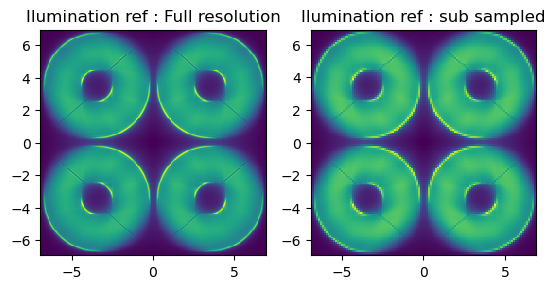

In [11]:
#showing the Reference
plt.subplot(1,2,1)
plt.title("Ilumination ref : Full resolution")
imshow_field(Iref)
plt.subplot(1,2,2)
plt.title("Ilumination ref : sub sampled")
imshow_field(Iref_bin)
plt.show()

In [12]:
zmodes = make_zernike_basis(200, Dtel, grid, 2)
dm = DeformableMirror(zmodes)

In [13]:
#### SLOPES 
# Right now, working without regularizations
# Slopes are an tranversed slopes

calibration_amplitude = 10e-9
dm.flatten()

slopes = []
for i in range(dm.num_actuators):
	if i % 10 == 0:
		print("Calibrating mode {:d}".format(i))

	slope = 0
	for s in [-1, 1]:
		dm.actuators[i] += s * calibration_amplitude

		im = 0		
		for wfi in mpwfs(dm(wf)):
			im += wfi.power
		im /=20
		im_binned = subsample_field(im, n_bin)

		slope += s * im_binned / (2 * calibration_amplitude)

		dm.actuators[i] -= s * calibration_amplitude
	slopes.append(slope)
# slopes to use, tranverse of images
slopes = np.array(slopes).T
# reconstruction matrix from inverse tikhonov
reconstruction_matrix = inverse_tikhonov(slopes,1e-3)
# save slopes matrix
np.save("save/slopes", slopes)

Calibrating mode 0


KeyboardInterrupt: 

In [14]:
# load slopes matrix
slopes = np.load("save/slopes.npy")

In [15]:
# number of illuminated actuators: 48
# q is our zero padding. we're at 4 now probably need to increase
ff = FourierFilter(grid, make_rectangular_aperture(2 * np.pi * 48 / Dtel), q=4)
ff_pad = FourierFilter(grid_pad, make_rectangular_aperture(2 * np.pi * 48 / Dtel), q=4)

In [16]:
# simplified aperture for minimizing funky ff residuals
circ_ap = evaluate_supersampled(make_circular_aperture(6.5), grid, 4)
circ_ap_pad = evaluate_supersampled(make_circular_aperture(6.5), grid_pad, 4)

### Test - padding, powerlaw, correct radians

In [17]:
def filter(phase, ff, ao_eff=1.0):
    phase_ms = phase - np.mean(phase)
    phase_filt = np.real(ff.forward(phase_ms +0j))
    phase_res = phase_ms - ao_eff * phase_filt
    return phase_res

def filter_crop(phase_pad, ff_pad, window_fn, ao_eff=1.0):
    phase_res_pad = filter(phase_pad, ff_pad, ao_eff=ao_eff)
    phase_res_crop = window_fn(phase_res_pad)
    return phase_res_crop

def PA_PL_phase(grid_p, diam, ff_p, window_fn, aperture, WFE_nm, wavelength, ao_eff=1.0, pl_exp=-11/3):
    ptv = 1 # TODO: check if this seems right
    phase_pl = make_power_law_error(grid_p, ptv, diam, exponent=pl_exp)
    phase_res_pl = filter_crop(phase_pl, ff_p, window_fn, ao_eff=ao_eff)
    # scaling 
    WFE_rad = WFE_nm * 2 * np.pi / wavelength # taking desired WFE to radians
    phase_res_pl *= WFE_rad / np.std(phase_res_pl[aperture>0])
    # create the PA optic - e^{i*phi} => expect phase 
    return phase_res_pl

def PA_LCO_phase(grid_p, ff_p, window_fn, r0, wavelength, L0=25, ao_eff=1.0):
    # generate the atmospheric layers 
    cn2 = atmosphere.Cn_squared_from_fried_parameter(r0)
    layer = atmosphere.InfiniteAtmosphericLayer(grid_p, cn2, L0=L0)
    phase_LCO = layer.phase_for(wavelength) # Field, units of radians
    # filter out modes AO can control.
    phase_res_LCO = filter_crop(phase_LCO, ff_p, window_fn, ao_eff=ao_eff)
    return phase_res_LCO

In [65]:
# powerlaw phase residuals
WFE_nm = 90e-9
pl_phase_res = PA_PL_phase(grid_pad, Dgrid*pad, ff_pad, crop_pad, aperture, WFE_nm, wavelength, ao_eff=1.0)
# LCO phase residual.s
r0 = 0.05
lco_phase_res = PA_LCO_phase(grid_pad, ff_pad, crop_pad, r0, wavelength, L0=25, ao_eff=1.0)

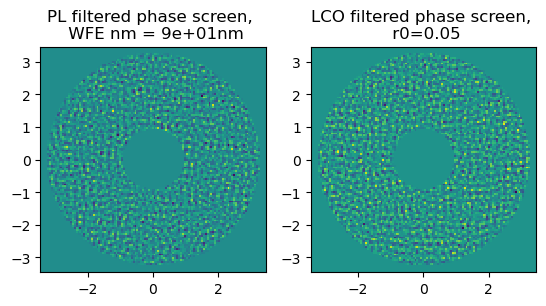

In [18]:
plt.subplot(1,2,1)
plt.title(f"PL filtered phase screen, \n WFE nm = {WFE_nm*1e9:0.2}nm")
imshow_field(pl_phase_res*aperture)

plt.subplot(1,2,2)
plt.title(f"LCO filtered phase screen, \n r0={r0}")
imshow_field(lco_phase_res*aperture)

plt.show()


### props for laughs

In [23]:
# setting up focal place propagation
spatial_resolution = wavelength / Dtel
focal_grid = make_focal_grid(q=8, num_airy=20, spatial_resolution=spatial_resolution)
prop = FraunhoferPropagator(grid, focal_grid)
psf_ref = prop(wf).power
norm = prop(wf).power.max()

In [24]:
# prop the power law residuals
abr_pl = PhaseApodizer(pl_phase_res*aperture)
psf_pl = prop(abr_pl(wf)).power

# prop the LCO residuals
abr_lco = PhaseApodizer(lco_phase_res*aperture)
psf_lco = prop(abr_lco(wf)).power

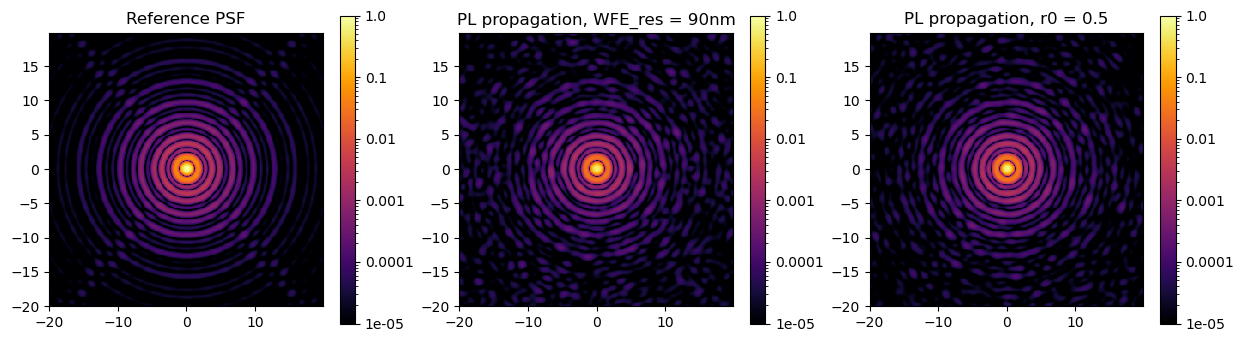

In [25]:
fig = plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.title("Reference PSF")
imshow_psf(psf_ref / norm, vmax=1, vmin=1e-5, spatial_resolution=spatial_resolution)

plt.subplot(1,3,2)
plt.title("PL propagation, WFE_res = 90nm")
imshow_psf(psf_pl / norm, vmax=1, vmin=1e-5, spatial_resolution=spatial_resolution)

plt.subplot(1,3,3)
plt.title("PL propagation, r0 = 0.5")
imshow_psf(psf_lco / norm, vmax=1, vmin=1e-5, spatial_resolution=spatial_resolution)

plt.show()

In [ ]:
# calculating the SR
SR_pl = get_strehl_from_focal(psf_pl, psf_ref).to_dict()['values']
SR_LCO = get_strehl_from_focal(psf_lco, psf_ref).to_dict()['values']

### Simulating PSDs again

In [66]:
pl_phase_res_100 = PA_PL_phase(grid_pad, Dgrid*pad, ff_pad, crop_pad, aperture, WFE_nm, wavelength, ao_eff=1.0)
pl_phase_res_98 = PA_PL_phase(grid_pad, Dgrid*pad, ff_pad, crop_pad, aperture, WFE_nm, wavelength, ao_eff=0.98)


In [67]:
fft = FastFourierTransform(grid, q=8, fov=0.5)
PSD_res_100 = abs(fft.forward(np.exp(1j*pl_phase_res_100)*aperture))**2
PSD_res_98 = abs(fft.forward(np.exp(1j*pl_phase_res_98)*aperture))**2

In [79]:
np.sqrt(230400)

480.0

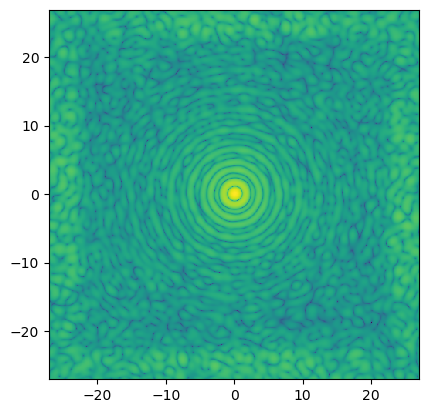

In [78]:
imshow_field(np.log(PSD_res_100))

In [80]:
#actual PSDs
n = 480
mid = 480//2
# create array of radii
x,y = np.meshgrid(np.arange(n),np.arange(n))
R = np.sqrt((x-mid)**2+(y-mid)**2)
r  = np.linspace(1,mid,num=mid)

# the 2d psds
PSD_2d_100 = PSD_res_100.reshape((n,n))
PSD_2d_98 = PSD_res_98.reshape((n,n))

# calculate the mean
f_psd = lambda r : PSD_2d_100[(R >= r-.5) & (R < r+.5)].mean()
mean_psd = np.vectorize(f_psd)(r)

f_filt = lambda r : PSD_2d_98[(R >= r-.5) & (R < r+.5)].mean()
mean_filt = np.vectorize(f_filt)(r)

r_x = np.linspace(0,48,num=mid)

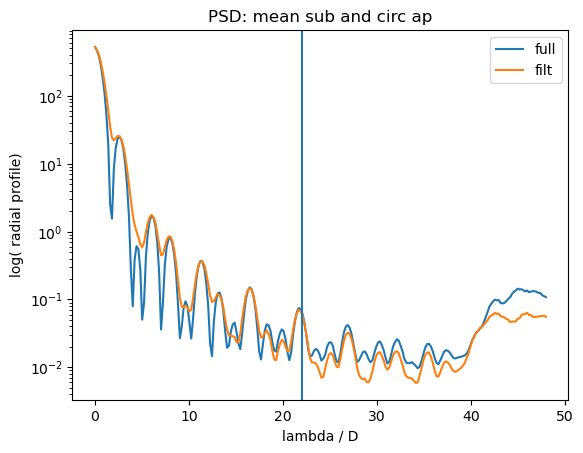

In [81]:
# plot it
fig,ax=plt.subplots()
plt.title("PSD: mean sub and circ ap")
ax.plot(r_x, mean_psd, label="full")
ax.plot(r_x, mean_filt, label="filt")
plt.axvline(22)
plt.yscale('log')
plt.xlabel('lambda / D')
plt.ylabel('log(radial profile)')
plt.legend()
plt.show()

## Trial 1: PyWFS response curves

In [18]:
mode_index = np.array([0, 40 , 180]) # zernike modes
amplitudes = np.linspace(0, 400e-9, 20) # DM pokes in m
AO = 0.98 # AO effectiveness

In [50]:
#### PURE COEFFICIENTS
# these don't depend on residual phase. 
dl_coef = np.zeros((mode_index.size, amplitudes.size))

for k, mi in enumerate(mode_index):
	for ai, amp in enumerate(amplitudes):
		# prepare DM
		dm.flatten()
		dm.actuators[mi] = amp
		# propagate wf
		wf_prop = mpwfs(dm(wf))
		# integrate on WFS
		im_binned = pywfs_int(wf_prop, n_bin)
		# direct reconstruction:
		dl_coef[k, ai] = slopes.T.dot( im_binned - Iref_bin )[mi] / np.linalg.norm(slopes[:,mi])**2

### Method 1: powerlaw

In [115]:
num_iterations = 10
coef_PL1 = np.zeros((mode_index.size, amplitudes.size, num_iterations))
WFE_PL1 = np.zeros((mode_index.size, amplitudes.size, num_iterations))
WFE_nm = 90e-9 # 120 nm

for k, mi in enumerate(mode_index):
    print(f"Starting mode: {mi}")
    for ai, amp in enumerate(amplitudes):
        for i in range(num_iterations):
            dm.flatten()
            dm.actuators[mi] = amp
            # use the premade function to calculate resigual phase
            phase_res = PA_PL_phase(grid_pad, Dgrid*pad, ff_pad, crop_pad, aperture, WFE_nm, wavelength, ao_eff=AO)
            # turn into a phase apodizer
            abr = PhaseApodizer(phase_res*aperture)
            # propagate wf
            wf_prop = mpwfs(abr(dm((wf))))
            # integrate on WFS
            im_binned = pywfs_int(wf_prop, n_bin)
            # direct reconstructions:
            coef_PL1[k, ai, i] = slopes.T.dot( im_binned - Iref_bin )[mi] / np.linalg.norm(slopes[:,mi])**2
            WFE_PL1[k, ai, i] = ts.phase_to_WFE(abr.phase[aperture>0], wavelength)


Starting mode: 0
Starting mode: 40
Starting mode: 180


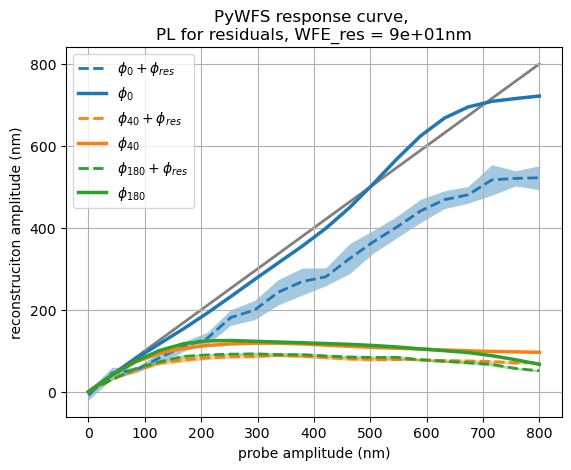

In [121]:
# PLOT: method one on pywfs response 
plt.title(f"PyWFS response curve, \nPL for residuals, WFE_res = {WFE_nm*1e9:0.2}nm")
plt.xlabel("probe amplitude (nm)")
plt.ylabel("reconstruciton amplitude (nm)")
# plot the response curve
amplitudes_wfe = 2*amplitudes # translateing from dm surface units to wfe units
for i in range(3):
	mean = 2*np.mean(coef_PL1, axis=2)[i] / 1e-9
	std = 2*np.std(coef_PL1, axis=2)[i] / 1e-9
	# dashed: average mode with errors
	plt.fill_between(amplitudes_wfe/1e-9, mean - std, mean + std, color='C{:d}'.format(i), alpha=0.4, lw=0)
	plt.plot(amplitudes_wfe/1e-9, mean, lw=2, color='C{:d}'.format(i), ls ='--', label=f'$\phi_{{{mode_index[i]:d}}} + \phi_{{res}}$')
	# solid: default
	plt.plot(amplitudes_wfe/1e-9, 2*dl_coef[i, :] / 1e-9, color='C{:d}'.format(i), ls='-', label=f'$\phi_{{{mode_index[i]:d}}}$', lw=2.5)
# plotting the average line
plt.plot(amplitudes_wfe/1e-9, amplitudes_wfe / 1e-9, color='gray', zorder=-1, lw=2)
# labels
#plt.ylim([0,200])
#plt.xlim([0,200])
plt.legend()
plt.grid()

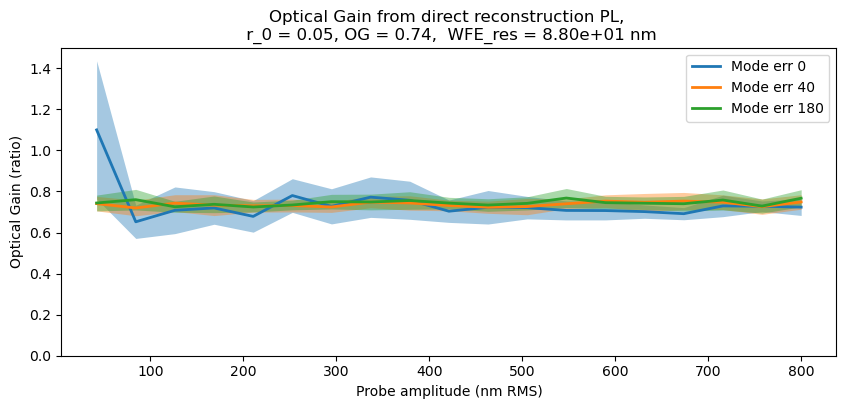

In [117]:
# Trial 1, Method 2 - are gains flat?
fig = plt.figure( figsize=(10,4), facecolor='white')
WFE_av = np.mean(WFE_PL1)
for i in range(3):
	amps = 2*amplitudes/1e-9 # in WFE units, not DM surface
	mean = 2*np.mean(coef_PL1, axis=2)[i] 
	std = 2*np.std(coef_PL1, axis=2)[i]
	gain =  mean / (2*dl_coef[i, :])
	gain_std = std / (2*dl_coef[i, :])
	# Optical gain ratios
	plt.fill_between(amps, gain - gain_std, gain + gain_std, color='C{:d}'.format(i), alpha=0.4, lw=0)
	plt.plot(amps, gain, lw=2, color='C{:d}'.format(i),  label='Mode err {:d}'.format(mode_index[i]))
# plotting the average line
plt.title(f"Optical Gain from direct reconstruction PL, \n r_0 = {r0}, OG = {np.mean(gain[np.isfinite(gain)]):.2f},  WFE_res = {WFE_av*1e9:.2e} nm")
plt.xlabel("Probe amplitude (nm RMS)")
plt.ylabel("Optical Gain (ratio)")
plt.ylim([0, 1.5])
plt.legend()
plt.show()

### Method 2: LCO generated phase screens

In [105]:
# generate phase screens
r0 = 0.05
num_iterations = 10
# list for filtered phse screens
phase_res_LCO1 = []
# AO filtering happening in phase screen generation!!
for i in range(num_iterations):
    lco_phase_res = PA_LCO_phase(grid_pad, ff_pad, crop_pad, r0, wavelength, L0=25, ao_eff=AO)
    phase_res_LCO1.append(lco_phase_res)

In [106]:
coef_LCO1 = np.zeros((mode_index.size, amplitudes.size, num_iterations))
WFE_LCO1 = np.zeros((mode_index.size, amplitudes.size, num_iterations))

for k, mi in enumerate(mode_index):
    print(f"Starting mode: {mi}")
    for ai, amp in enumerate(amplitudes):
        for i in range(num_iterations):
            dm.flatten()
            dm.actuators[mi] = amp
            # turn into a phase apodizer
            abr = PhaseApodizer(phase_res_LCO1[i]*aperture)
            # propagate wf
            wf_prop = mpwfs(abr(dm((wf))))
            # integrate on WFS
            im_binned = pywfs_int(wf_prop, n_bin)
            # direct reconstructions:
            coef_LCO1[k, ai, i] = slopes.T.dot( im_binned - Iref_bin )[mi] / np.linalg.norm(slopes[:,mi])**2
            WFE_LCO1[k, ai, i] = ts.phase_to_WFE(abr.phase[aperture>0], wavelength)

Starting mode: 0


Starting mode: 40
Starting mode: 180


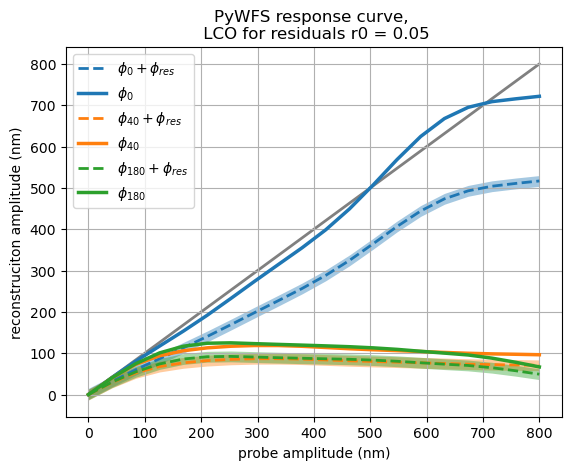

In [122]:
# PLOT: method one on pywfs response 
plt.title(f"PyWFS response curve, \n LCO for residuals r0 = {r0}")
plt.xlabel("probe amplitude (nm)")
plt.ylabel("reconstruciton amplitude (nm)")
# plot the response curve
amplitudes_wfe = 2*amplitudes # translateing from dm surface units to wfe units
for i in range(3):
	mean = 2*np.mean(coef_LCO1, axis=2)[i] / 1e-9
	std = 2*np.std(WFE_LCO1, axis=2)[i] / 1e-9
	# dashed: average mode with errors
	plt.fill_between(amplitudes_wfe/1e-9, mean - std, mean + std, color='C{:d}'.format(i), alpha=0.4, lw=0)
	plt.plot(amplitudes_wfe/1e-9, mean, lw=2, color='C{:d}'.format(i), ls ='--', label=f'$\phi_{{{mode_index[i]:d}}} + \phi_{{res}}$')
	# solid: default
	plt.plot(amplitudes_wfe/1e-9, 2*dl_coef[i, :] / 1e-9, color='C{:d}'.format(i), ls='-', label=f'$\phi_{{{mode_index[i]:d}}}$', lw=2.5)
# plotting the average line
plt.plot(amplitudes_wfe/1e-9, amplitudes_wfe / 1e-9, color='gray', zorder=-1, lw=2)
#plt.ylim([0,200])
#plt.xlim([0,200])
plt.legend()
plt.grid()
plt.show()

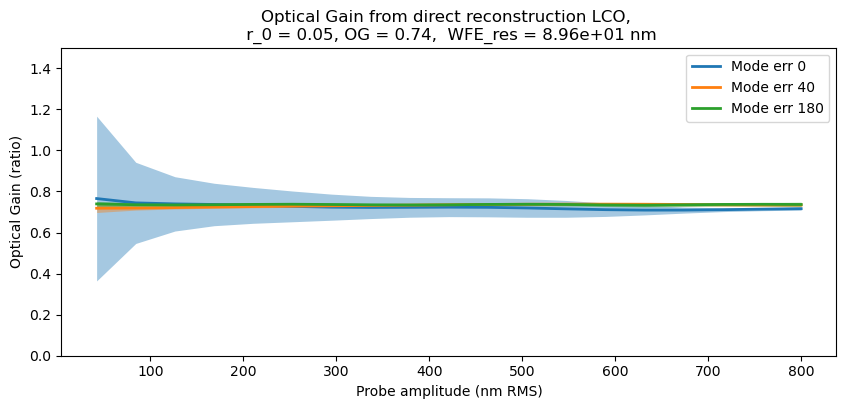

In [114]:
# Trial 1, Method 2 - are gains flat?
fig = plt.figure( figsize=(10,4), facecolor='white')
WFE_av = np.mean(WFE_LCO1)
for i in range(3):
	amps = 2*amplitudes/1e-9 # in WFE units, not DM surface
	mean = 2*np.mean(coef_LCO1, axis=2)[i] 
	std = 2*np.std(coef_LCO1, axis=2)[i]
	gain =  mean / (2*dl_coef[i, :])
	gain_std = std / (2*dl_coef[i, :])
	# Optical gain ratios
	plt.fill_between(amps, gain - gain_std, gain + gain_std, color='C{:d}'.format(i), alpha=0.4, lw=0)
	plt.plot(amps, gain, lw=2, color='C{:d}'.format(i),  label='Mode err {:d}'.format(mode_index[i]))
# plotting the average line
plt.title(f"Optical Gain from direct reconstruction LCO, \n r_0 = {r0}, OG = {np.mean(gain[np.isfinite(gain)]):.2f},  WFE_res = {WFE_av*1e9:.2e} nm")
plt.xlabel("Probe amplitude (nm RMS)")
plt.ylabel("Optical Gain (ratio)")
plt.ylim([0, 1.5])
plt.legend()
plt.show()

## Trial 2: OG vs. WFS residuals (3 modes)

Iterating over the strength of turbulence to see how OG changes against turbulence strength

In [19]:
trials = 2
# the residuals to iter over
residuals = np.linspace(1e-11, 400e-9, 50) 
# hudgens equivalents
r_0_eq = np.array([ts.inv_hugens(res) for res in residuals]) # using hugens to approx r0 per WFE_res

### Method 1: powerlaw

In [20]:
# Power Law residual phases
phase_res_PL2 = []
# get a new value per residual value
for res in residuals:
    phase_tmp = []
    for i in range(trials): 
        phase_res = PA_PL_phase(grid_pad, Dgrid*pad, ff_pad, crop_pad, aperture, res, wavelength, ao_eff=AO)
        phase_tmp.append(phase_res)
    phase_res_PL2.append(phase_tmp)

In [21]:
# optical gain by residual
num_iterations = trials
coef_PL2 = np.zeros((mode_index.size, residuals.size, num_iterations))
WFE_PL2 = np.zeros((mode_index.size, residuals.size, num_iterations))
test_amp = 10e-9

for k, mi in enumerate(mode_index):
	for ri, res in enumerate(residuals):
		for i in range(num_iterations):
			dm.flatten()
			dm.actuators[mi] = test_amp
			#making sure the 
			if ri == 0:
				abr = PhaseApodizer(aperture)
				wf_prop = mpwfs(dm(wf))
			else:
				abr = PhaseApodizer(phase_res_PL2[ri][i]*aperture)
				wf_prop = mpwfs(abr(dm((wf))))
			# integrate on WFS
			im_binned = pywfs_int(wf_prop, n_bin)
			#direct reconstruction:
			coef_PL2[k, ri, i] = slopes.T.dot(im_binned - Iref_bin )[mi] / np.linalg.norm(slopes[:,mi])**2
			WFE_PL2[k, ri, i] = ts.phase_to_WFE(abr.phase[aperture>0], wavelength)

In [22]:
# Naively, the amount of residual WFE = SR
res_rads = 2*np.pi*residuals/wavelength
strehl = np.exp(-(res_rads)**2)
strehl_alph = np.exp(-(0.8*res_rads)**2)
strehl_beta = np.exp(-(res_rads/np.sqrt(2))**2)

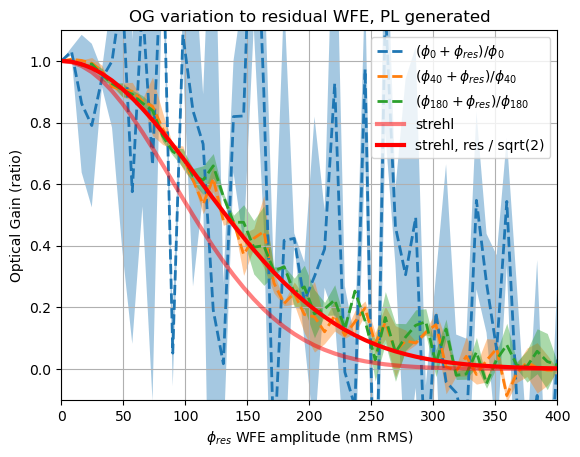

In [26]:
# PLOT: Trial 2, method 1 
plt.title(f"OG variation to residual WFE, PL generated")
plt.xlabel(f'$\phi_{{res}}$ WFE amplitude (nm RMS)')
plt.ylabel("Optical Gain (ratio)")
# Calc and plot 
test_amp_div = 2*test_amp
for i in range(3):
	mean = np.mean(coef_PL2, axis=2)[i] 
	std = np.std(coef_PL2, axis=2)[i] 
	gain = mean / test_amp
	std_gain = std / test_amp
	# Plotting OG with error bars
	plt.fill_between(residuals/1e-9, gain - std_gain, gain + std_gain, color='C{:d}'.format(i), alpha=0.4, lw=0)
	plt.plot(residuals/1e-9, gain, lw=2, color='C{:d}'.format(i), ls ='--', label=f'$(\phi_{{{mode_index[i]:d}}} + \phi_{{res}}) / \phi_{{{mode_index[i]:d}}} $')	
# plotting the average line
plt.plot(residuals/1e-9, strehl, color = 'red', alpha=0.5, label='strehl', lw = 3)
plt.plot(residuals/1e-9, strehl_alph, color = 'red', label='strehl, res / sqrt(2)', lw = 3)

plt.xlim(0, 400)
plt.ylim(-0.1, 1.1)
plt.legend()
plt.grid()
plt.show()

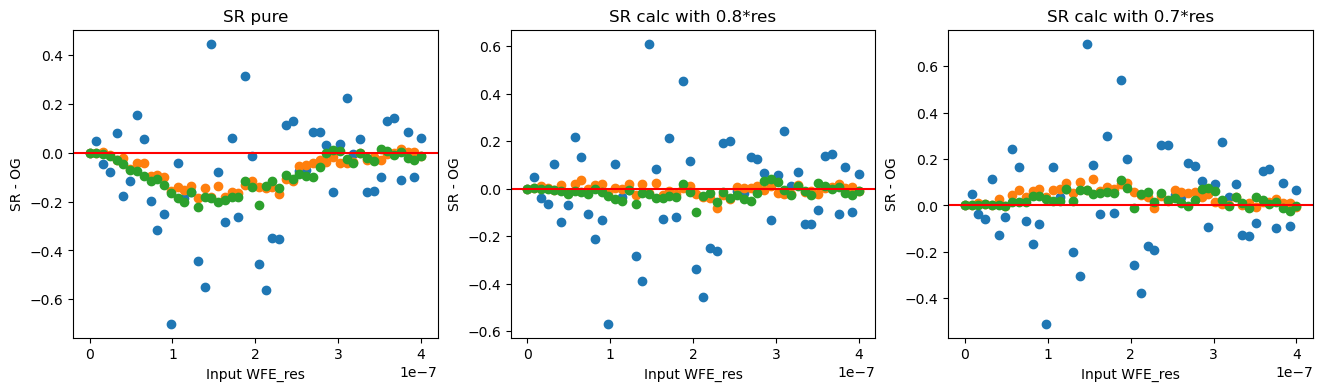

In [86]:
# to compare, difference between OG and SR:
fig = plt.figure(figsize=(16,4))

mean = np.mean(coef_PL2, axis=2)

plt.subplot(1,3,1)
plt.axhline(0, c='r')
for i in range(3):
    gain = mean[i] / test_amp
    plt.scatter(residuals, strehl - gain)
plt.title("SR pure")
plt.xlabel("Input WFE_res")
plt.ylabel("SR - OG")

plt.subplot(1,3,2)
plt.axhline(0, c='r')
for i in range(3):
    gain = mean[i] / test_amp
    plt.scatter(residuals, strehl_alph - gain)
plt.title("SR calc with 0.8*res")
plt.xlabel("Input WFE_res")
plt.ylabel("SR - OG")

plt.subplot(1,3,3)
plt.axhline(0, c='r')
for i in range(3):
    gain = mean[i] / test_amp
    plt.scatter(residuals, strehl_beta - gain)
plt.title("SR calc with 0.7*res")
plt.xlabel("Input WFE_res")
plt.ylabel("SR - OG")

plt.show()


### Method 2: LCO residuals

In [88]:
# Power Law residual phases
phase_res_LCO2 = []
# get a new value per residual value
for r0 in r_0_eq:
    phase_tmp = []
    for i in range(trials): 
        lco_phase_res = PA_LCO_phase(grid_pad, ff_pad, crop_pad, r0, wavelength, L0=25, ao_eff=AO)
        phase_tmp.append(lco_phase_res)
    phase_res_LCO2.append(phase_tmp)

In [89]:
# optical gain by residual
num_iterations = trials
coef_LCO2 = np.zeros((mode_index.size, residuals.size, num_iterations))
WFE_LCO2 = np.zeros((mode_index.size, residuals.size, num_iterations))
test_amp = 10e-9

for k, mi in enumerate(mode_index):
	for ri, res in enumerate(residuals):
		for i in range(num_iterations):
			dm.flatten()
			dm.actuators[mi] = test_amp
			#making sure the 
			if ri == 0:
				abr = PhaseApodizer(aperture)
				wf_prop = mpwfs(dm(wf))
			else:
				abr = PhaseApodizer(phase_res_LCO2[ri][i]*aperture)
				wf_prop = mpwfs(abr(dm((wf))))
			# integrate on WFS
			im_binned = pywfs_int(wf_prop, n_bin)
			#direct reconstruction:
			coef_LCO2[k, ri, i] = slopes.T.dot(im_binned - Iref_bin )[mi] / np.linalg.norm(slopes[:,mi])**2
			WFE_LCO2[k, ri, i] = ts.phase_to_WFE(abr.phase[aperture>0], wavelength)

In [91]:
# Naively, the amount of residual WFE = SR
residuals_avg = np.mean(WFE_LCO2[1:,:,:], axis=(0,2))
res_rads = 2*np.pi*residuals_avg/wavelength
strehl = np.exp(-(res_rads)**2)
strehl_alph = np.exp(-(0.8*res_rads)**2)

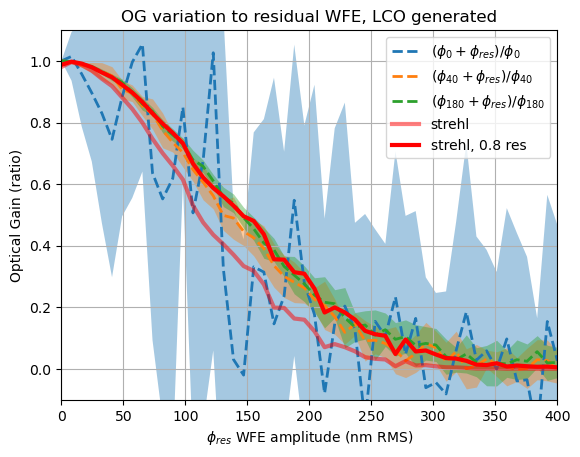

In [ ]:
# PLOT: Trial 2, method 1 
plt.title(f"OG variation to residual WFE, LCO generated")
plt.xlabel(f'$\phi_{{res}}$ WFE amplitude (nm RMS)')
plt.ylabel("Optical Gain (ratio)")
# Calc and plot 
for i in range(3):
	mean = np.mean(coef_LCO2, axis=2)[i] 
	std = np.std(coef_LCO2, axis=2)[i] 
	gain = mean / test_amp
	std_gain = std / test_amp
	# Plotting OG with error bars
	plt.fill_between(residuals/1e-9, gain - std_gain, gain + std_gain, color='C{:d}'.format(i), alpha=0.4, lw=0)
	plt.plot(residuals/1e-9, gain, lw=2, color='C{:d}'.format(i), ls ='--', label=f'$(\phi_{{{mode_index[i]:d}}} + \phi_{{res}}) / \phi_{{{mode_index[i]:d}}} $')	
# plotting the average line
plt.plot(residuals/1e-9, strehl, color = 'red', alpha=0.5, label='strehl avg', lw = 3)
plt.plot(residuals/1e-9, strehl_alph, color = 'red', label='strehl, 0.8 res', lw = 3)

plt.xlim(0, 400)
plt.ylim(-0.1, 1.1)
plt.legend()
plt.grid()
plt.show()

## Trial 3: OG vs. modes (against 5 r_0s)

In [93]:
num_iterations = 10
modes_tested = np.arange(0, 200, 10)
residuals_test = np.array([0, 10e-9, 25e-9, 50e-9, 100e-9, 200e-9])
r_0_eq_test = np.array([ts.inv_hugens(res) for res in residuals_test]) 

### Method 1: Powerlaw

In [94]:
# Power Law residual phases
phase_res_PL3 = []
# get a new value per residual value
for res in residuals_test:
    phase_tmp = []
    for i in range(trials): 
        phase_res = PA_PL_phase(grid_pad, Dgrid*pad, ff_pad, crop_pad, aperture, res, wavelength, ao_eff=AO)
        phase_tmp.append(phase_res)
    phase_res_PL3.append(phase_tmp)

In [95]:
# OG by MODE
coef_PL3 = np.zeros((residuals_test.size, modes_tested.size, num_iterations))
WFE_PL3 = np.zeros((residuals_test.size, modes_tested.size, num_iterations))
test_amp = 10e-9

for ri, res in enumerate(residuals_test):
	for k, mi in enumerate(modes_tested):
		for i in range(num_iterations):
			dm.flatten()
			dm.actuators[mi] = test_amp
			if ri == 0:
				abr = PhaseApodizer(aperture)
				wf_prop = mpwfs(dm(wf))
			else:
				abr = PhaseApodizer(phase_res_PL3[ri][i]*aperture)
				wf_prop = mpwfs(abr(dm((wf))))
			# integrate on WFS
			im_binned = pywfs_int(wf_prop, n_bin)
			#direct reconstruction:
			coef_PL3[ri, k, i] = slopes.T.dot( im_binned - Iref_bin )[mi] / np.linalg.norm(slopes[:,mi])**2
			WFE_PL3[ri, k, i] = ts.phase_to_WFE(abr.phase[aperture>0], wavelength)

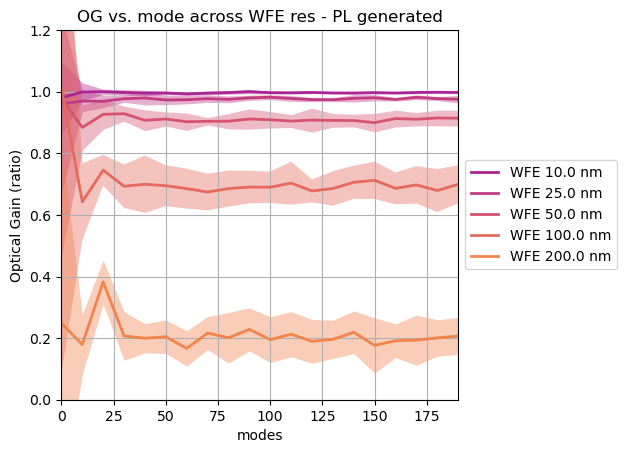

In [99]:
# plot: jsut the Mode to OG value
fig = plt.figure()
ax = plt.subplot(111)
colors = plt.cm.plasma(np.linspace(0.3,.7, len(residuals_test)))

for i in range(1,len(residuals_test)):
	mean = np.mean(coef_PL3, axis=2)[i] 
	std = np.std(coef_PL3, axis=2)[i] 
	gain = mean / test_amp
	std_gain = std / test_amp
	# dashed: average mode with errors
	ax.fill_between(modes_tested, gain - std_gain, gain + std_gain,  alpha=0.4, lw=0, color=colors[i])
	ax.plot(modes_tested, gain, lw=2, ls ='-', label=f'WFE {residuals_test[i]/1e-9 :0.4} nm',  c=colors[i])
	# solid: default
	
# plotting the average line
plt.title(f"OG vs. mode across WFE res - PL generated")
plt.xlabel("modes")
plt.ylabel("Optical Gain (ratio)")
plt.legend()
plt.xlim(0,190)
plt.ylim(0.0, 1.2)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid()
plt.show()

### Method 2: LCO generation

In [100]:
# Power Law residual phases
phase_res_LCO3 = []
# get a new value per residual value
for r0 in r_0_eq_test:
    phase_tmp = []
    for i in range(trials): 
        lco_phase_res = PA_LCO_phase(grid_pad, ff_pad, crop_pad, r0, wavelength, L0=25, ao_eff=AO)
        phase_tmp.append(lco_phase_res)
    phase_res_LCO3.append(phase_tmp)

In [102]:
# OG by MODE
coef_LCO3 = np.zeros((residuals_test.size, modes_tested.size, num_iterations))
WFE_LCO3 = np.zeros((residuals_test.size, modes_tested.size, num_iterations))
test_amp = 10e-9

for ri, res in enumerate(residuals_test):
	for k, mi in enumerate(modes_tested):
		for i in range(num_iterations):
			dm.flatten()
			dm.actuators[mi] = test_amp
			if ri == 0:
				abr = PhaseApodizer(aperture)
				wf_prop = mpwfs(dm(wf))
			else:
				abr = PhaseApodizer(phase_res_LCO3[ri][i]*aperture)
				wf_prop = mpwfs(abr(dm((wf))))
			# integrate on WFS
			im_binned = pywfs_int(wf_prop, n_bin)
			#direct reconstruction:
			coef_LCO3[ri, k, i] = slopes.T.dot( im_binned - Iref_bin )[mi] / np.linalg.norm(slopes[:,mi])**2
			WFE_LCO3[ri, k, i] = ts.phase_to_WFE(abr.phase[aperture>0], wavelength)

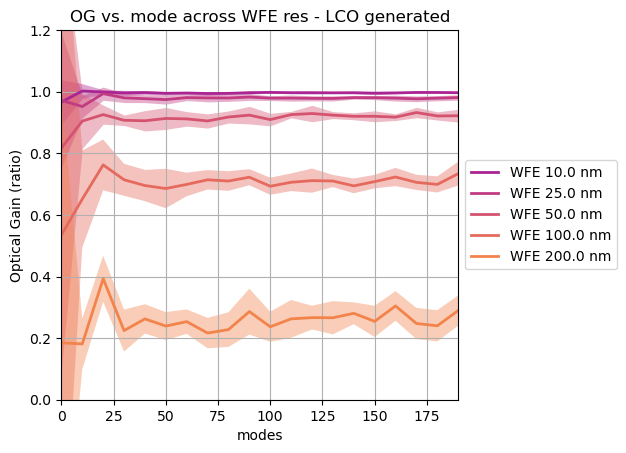

In [104]:
# plot: jsut the Mode to OG value
fig = plt.figure()
ax = plt.subplot(111)
colors = plt.cm.plasma(np.linspace(0.3,.7, len(residuals_test)))

for i in range(1,len(residuals_test)):
	mean = np.mean(coef_LCO3, axis=2)[i] 
	std = np.std(coef_LCO3, axis=2)[i] 
	gain = mean / test_amp
	std_gain = std / test_amp
	# dashed: average mode with errors
	ax.fill_between(modes_tested, gain - std_gain, gain + std_gain,  alpha=0.4, lw=0, color=colors[i])
	ax.plot(modes_tested, gain, lw=2, ls ='-', label=f'WFE {residuals_test[i]/1e-9 :0.4} nm',  c=colors[i])
	# solid: default
	
# plotting the average line
plt.title(f"OG vs. mode across WFE res - LCO generated")
plt.xlabel("modes")
plt.ylabel("Optical Gain (ratio)")
plt.legend()
plt.xlim(0,190)
plt.ylim(0.0, 1.2)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid()
plt.show()

## Trial 4: OG vs. Merichial vs found SR

The goal for this trial is to iterate similarly to **Trial 3** but to propagate each wavefront and get a PSF SR number. This we will plot one to one with the Merechal approx on the residual WFE to see if we're introducing a bias. 

In [35]:
def calc_psf_SR(phase_res, aperture, wf, prop, psf_ref):
    abr = PhaseApodizer(phase_res*aperture)
    psf = prop(abr(wf)).power
    strehl = get_strehl_from_focal(psf, psf_ref).to_dict()['values']
    return strehl

def calc_approx_SR(phase_res, aperture):
    WFE_rads = np.std(phase_res[aperture>0])
    strehl = np.exp(-(WFE_rads)**2)
    return strehl

In [33]:
trials = 5
AO=0.98
# the residuals to iter over
residuals = np.linspace(1e-11, 400e-9, 50) 
# hudgens equivalents
r_0_eq = np.array([ts.inv_hugens(res) for res in residuals]) # using hugens to approx r0 per WFE_res

In [37]:
# Power Law residual phases
phase_res_PL4 = []
SR_psf_PL4 = []
SR_aprx_PL4 = []
# get a new value per residual value
for res in residuals:
    phase_tmp = []
    SR_psf_tmp = []
    SR_aprx_tmp = []
    for i in range(trials): 
        phase_res = PA_PL_phase(grid_pad, Dgrid*pad, ff_pad, crop_pad, aperture, res, wavelength, ao_eff=AO)
        SR_psf = calc_psf_SR(phase_res, aperture, wf, prop, psf_ref)
        SR_aprx = calc_approx_SR(phase_res, aperture)
        #save in temp
        phase_tmp.append(phase_res)
        SR_psf_tmp.append(SR_psf)
        SR_aprx_tmp.append(SR_aprx)
    # add each trial
    phase_res_PL4.append(phase_tmp)
    SR_psf_PL4.append(SR_psf_tmp)
    SR_aprx_PL4.append(SR_aprx_tmp)

In [41]:
SR_psf_PL4 = np.array(SR_psf_PL4)
SR_aprx_PL4 = np.array(SR_aprx_PL4)

[]

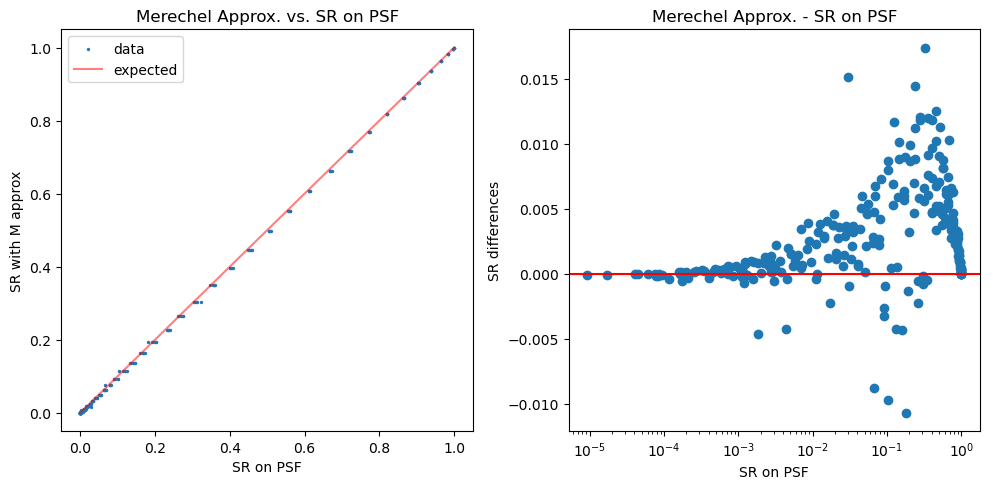

In [64]:
mean_psf = np.mean(SR_psf_PL4, axis=1)
mean_aprx = np.mean(SR_aprx_PL4, axis=1)
std_psf = np.std(SR_psf_PL4, axis=1)
std_aprx = np.std(SR_aprx_PL4, axis=1)

x = np.linspace(0, 1, 50)
y = x

# plotting
fig = plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title("Merechel Approx. vs. SR on PSF")
plt.xlabel("SR on PSF")
plt.ylabel("SR with M approx")
plt.scatter(SR_psf_PL4.flatten(), SR_aprx_PL4.flatten(), label = "data", s=2)
plt.plot(x, y, c="r", alpha=0.5, label = "expected")
plt.legend()

plt.subplot(1,2,2)
plt.title("Merechel Approx. - SR on PSF")
plt.xlabel("SR on PSF")
plt.ylabel("SR differences")
plt.scatter(SR_psf_PL4.flatten(), SR_psf_PL4.flatten() - SR_aprx_PL4.flatten())
plt.axhline(0, c="r")
plt.xscale("log")

plt.tight_layout()
plt.plot()

## Trial 5: how does PL affect SR response

In [43]:
num_iterations = 20
mode_pl_index = np.array([1, 2 , 5]) # zernike modes
residuals = np.linspace(0, 400e-9, 100) # DM pokes in m
pl_exp = np.array([ -2.5, -3, -11/3, -4, -5])

In [44]:
# Itering over the pwower laws
coef_PL5 = np.zeros((pl_exp.size, residuals.size, num_iterations))
WFE_PL5 = np.zeros((pl_exp.size, residuals.size, num_iterations))

test_amp = 10e-9
mi = 40
AO = 0.98

for k, pl in enumerate(pl_exp):
    print(f"Starting pl exp: {pl}")
    for ri, res in enumerate(residuals):
        for i in range(num_iterations):
            dm.flatten()
            dm.actuators[mi] = test_amp
            # use the premade function to calculate resigual phase
            phase_res = PA_PL_phase(grid_pad, Dgrid*pad, ff_pad, crop_pad, aperture, res, wavelength, ao_eff=AO, pl_exp=pl)
            # turn into a phase apodizer
            abr = PhaseApodizer(phase_res*aperture)
            # propagate wf
            wf_prop = mpwfs(abr(dm((wf))))
            # integrate on WFS
            im_binned = pywfs_int(wf_prop, n_bin)
            # direct reconstructions:
            coef_PL5[k, ri, i] = slopes.T.dot( im_binned - Iref_bin )[mi] / np.linalg.norm(slopes[:,mi])**2
            WFE_PL5[k, ri, i] = ts.phase_to_WFE(abr.phase[aperture>0], wavelength)



Starting pl exp: -2.5


Starting pl exp: -3.0
Starting pl exp: -3.6666666666666665
Starting pl exp: -4.0
Starting pl exp: -5.0


In [58]:
res_rads = 2*np.pi*residuals/wavelength
strehl = np.exp(-(res_rads)**2)
strehl_OG = np.exp(-(0.8*res_rads)**2)

[]

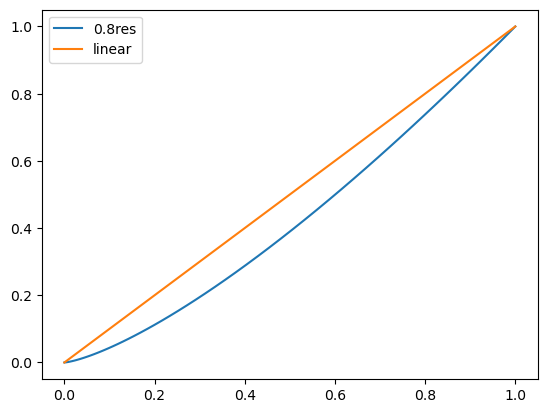

In [64]:
curve = strehl / strehl_OG
lin_rel = strehl / strehl

plt.plot(strehl, curve*strehl, label='0.8res')
plt.plot(strehl, lin_rel*strehl,label='linear')
plt.legend()
plt.plot()

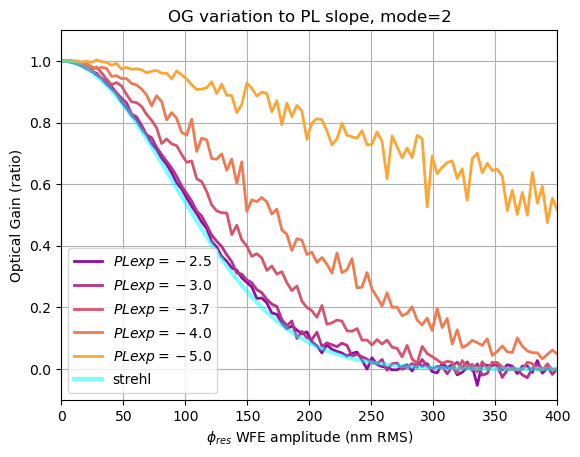

In [57]:
# PLOT: deviation from 
mean_pl = np.mean(coef_PL5, axis=2)
std_pl = np.std(coef_PL5, axis=2)

colors  = plt.cm.plasma(np.linspace(0.3, 0.8, len(pl_exp)))

plt.title(f"OG variation to PL slope, mode=2")
plt.xlabel(f'$\phi_{{res}}$ WFE amplitude (nm RMS)')
plt.ylabel("Optical Gain (ratio)")

# Calc and plot 
for i in range(len(pl_exp)):
    mean = mean_pl[i] 
    std = std_pl[i] 
    # divide by test amp to get OG
    gain = mean / test_amp
    std_gain = std / test_amp
    # Plotting OG with error bars
    #plt.fill_between(residuals/1e-9, gain - std_gain, gain + std_gain, color='C{:d}'.format(i), alpha=0.4, lw=0)
    plt.plot(residuals/1e-9, gain, lw=2, color=colors[i], label=f'$PL exp = {pl_exp[i]:0.2} $')	
# plotting the average line
plt.plot(residuals/1e-9, strehl, color = 'cyan', alpha=0.5, label='strehl', lw = 3)

plt.xlim(0, 400)
plt.ylim(-0.1, 1.1)
plt.legend()
plt.grid()
plt.show()

In [ ]:
# fitting error = exp -11/3 (cut in center)
# photon noise = white noise (within control region up to fitting error)
# 

### Trial 6: PSD

In [92]:
def filter_v(phase, ff, ao_eff=1.0):
    phase_ms = phase - np.mean(phase)
    phase_filt = np.real(ff.forward(phase_ms +0j))
    phase_res = phase_ms - ao_eff * phase_filt
    return phase_res, phase_filt, phase_ms

def PA_PL_phase_v(grid_p, diam, ff_p, aperture, WFE_nm, wavelength, ao_eff=1.0, pl_exp=-11/3):
    ptv = 1 # TODO: check if this seems right
    phase_pl = make_power_law_error(grid_p, ptv, diam, exponent=pl_exp)
    phase_res_pl, phase_filt_pl, phase_ms_pl = filter_v(phase_pl, ff_p, ao_eff=ao_eff)
    # scaling 
    WFE_rad = WFE_nm * 2 * np.pi / wavelength # taking desired WFE to radians
    phase_res_pl *= WFE_rad / np.std(phase_res_pl[aperture>0])
    phase_filt_pl *= WFE_rad / np.std(phase_res_pl[aperture>0])
    phase_ms_pl *= WFE_rad / np.std(phase_res_pl[aperture>0])
    # create the PA optic - e^{i*phi} => expect phase 
    return phase_res_pl, phase_filt_pl, phase_ms_pl

def PA_LCO_phase_v(grid_p, ff_p, r0, wavelength, L0=25, ao_eff=1.0):
    # generate the atmospheric layers 
    cn2 = atmosphere.Cn_squared_from_fried_parameter(r0)
    layer = atmosphere.InfiniteAtmosphericLayer(grid_p, cn2, L0=L0)
    phase_LCO = layer.phase_for(wavelength) # Field, units of radians
    # filter out modes AO can control.
    phase_res, phase_filt, phase_ms = filter_v(phase_LCO, ff_p, ao_eff=ao_eff)
    return phase_res, phase_filt, phase_ms

In [93]:
WFE_nm = 90e-9
r0 = 0.05
phase_res_pl, phase_filt_pl, phase_ms_pl = PA_PL_phase_v(grid_pad, Dgrid*pad, ff_pad, aperture_pad, WFE_nm, wavelength, ao_eff=1.0)

In [94]:
phase_res_lco, phase_filt_lco, phase_ms_lco = PA_LCO_phase_v(grid_pad, ff_pad, r0, wavelength, L0=25, ao_eff=1.0)

In [113]:
fft = FastFourierTransform(grid_pad, q=8, fov=0.5)

PSD = abs(fft.forward(np.exp(1j*phase_ms_pl)))**2
PSD_filt = abs(fft.forward(np.exp(1j*phase_filt_pl)))**2
PSD_res = abs(fft.forward(np.exp(1j*phase_res_pl)))**2

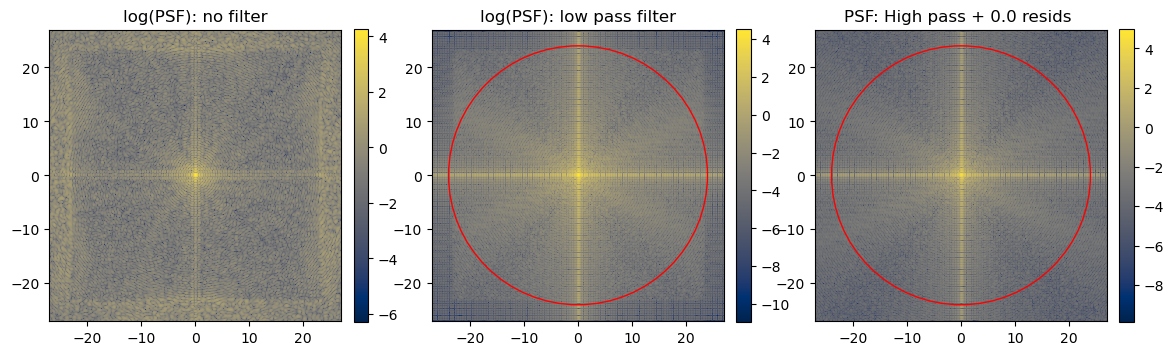

In [102]:
fig = plt.figure(figsize=(14,5), facecolor='white')
# expected control region

plt.subplot(1,3,1)
plt.title("log(PSF): no filter")
imshow_field(np.log10(PSD), cmap='cividis')
plt.colorbar(fraction=0.046, pad=0.04)

#########################
plt.subplot(1,3,2)
plt.title("log(PSF): low pass filter")
imshow_field(np.log10(PSD_filt), cmap='cividis')
circle1 = plt.Circle((0, 0), 24, color='r', fill=False)
plt.gca().add_patch(circle1)
plt.colorbar(fraction=0.046, pad=0.04)

#############################
plt.subplot(1,3, 3)
plt.title("PSF: High pass + 0.0 resids ")
imshow_field(np.log10(PSD_res), vmax=5, cmap='cividis')
circle2 = plt.Circle((0, 0), 24, color='r', fill=False)
plt.gca().add_patch(circle2)
plt.colorbar(fraction=0.046, pad=0.04)

plt.show()

In [104]:
from photutils.profiles import RadialProfile

In [107]:
n = int(np.sqrt(PSD.shape))
data = PSD.reshape(n,n)

In [108]:
center = (n//2, n//2)
edge_radii = np.arange(n//2)
rp = RadialProfile(data, center, edge_radii)

In [111]:
rp

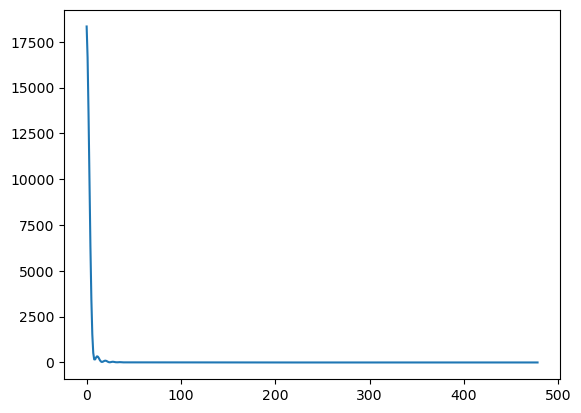

In [112]:
plt.plot(rp.profile)

In [ ]:
plt.